## Octave code to simulate sigma-point Kalman filter for simple example
This code simulates the example introduced in lesson 3.5.4 and is a straightforward implementation of the six sigma-point Kalman-filter steps on a simple model. You will use this code to answer the practice-quiz questions for this lesson. Feel free to add your own statements to plot or output variables computed by the filter to help you understand better how it works.

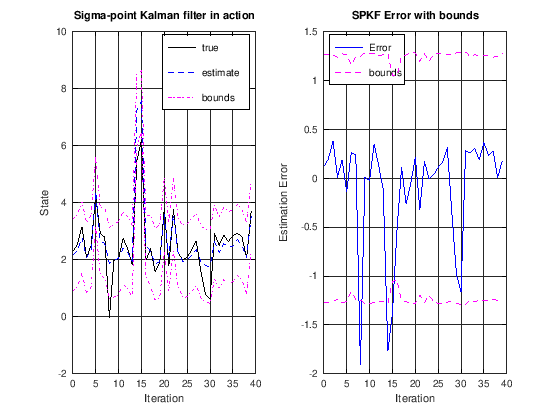

In [1]:
% Initialize simulation variables
SigmaW = 1; % Process noise covariance
SigmaV = 2; % Sensor noise covariance
maxIter = 40;

% Seed the random number generator: Octave's "randn" function produces pseudo 
% random numbers having a Gaussian distribution. To get the same random numbers
% every time you run the code, you can "seed" the pseudo random number generator 
% with a deterministic value. This allows us to get reproducible results that 
% still contain apparent randomness.
%
% YOU MUST NOT CHANGE THE FOLLOWING LINE IN ORDER TO ARRIVE AT "CORRECT" ANSWERS 
% FOR THE QUIZ. IF YOU CHANGE IT TO EXPLORE THE BEHAVIOR OF THE FILTER FOR 
% DIFFERENT PSEUDO-RANDOM SEQUENCES, CHANGE IT BACK TO randn("seed",-1) BEFORE 
% COMPUTING RESULTS TO ENTER AS QUIZ RESPONSES.
randn("seed",-1);

% Define size of variables in model
Nx = 1;     % state  = 1x1 scalar
Nxa = 3;    % augmented state has also w(k) and v(k) contributions
Nz = 1;     % output = 1x1 scalar

% Some constants for the SPKF algorithm. Use standard values for
% cases with Gaussian noises.  (These are the weighting matrices
% comprising the values of alpha(c) and alpha(m) organized in a way to
% make later computation efficient).
h = sqrt(3);
Wmx(1) = (h*h-Nxa)/(h*h); Wmx(2) = 1/(2*h*h); Wcx=Wmx;
repWmxz = repmat([Wmx(1) repmat(Wmx(2),[1 2*Nxa])],1); 

xtrue = 2 + randn(1);  % Initialize true system initial state
xhat = 2;           % Initialize Kalman filter initial estimate
SigmaX = 1;	           % Initialize Kalman filter covariance

% Reserve storage for variables we might want to plot/evaluate
xstore = zeros(length(xtrue),maxIter+1); xstore(:,1) = xtrue;
zstore = zeros(1,maxIter);

% Reserve storage for variables we might want to plot/evaluate
xhatstore = zeros(length(xhat),maxIter);
SigmaXstore = zeros(length(xhat)^2,maxIter);
for k = 1:maxIter,
  % SPKF Step 1: State estimate time update
  % 1a: Calculate augmented state estimate, including ...
  xhata = [xhat; 0; 0]; % process and sensor noise mean
  % 1b: Get desired Cholesky factor
  Pxa = blkdiag(SigmaX,SigmaW,SigmaV);
  sPxa = chol(Pxa,'lower');   
  % 1c: Calculate sigma points (strange indexing of xhat to avoid
  % "repmat" call, which is very inefficient in Matlab)
  X = xhata(:,ones([1 2*Nxa+1])) + h*[zeros([Nxa 1]), sPxa, -sPxa];
  % 1d: Calculate state equation for every element
  % Hard-code equation here for efficiency
  Xx = sqrt(5+X(1,:)) + X(2,:);
  xhat = Xx*repWmxz';

  % SPKF Step 2: Covariance of prediction
  Xs = (Xx(:,2:end) - xhat(:,ones([1 2*Nxa])))*sqrt(Wcx(2));
  Xs1 = Xx(:,1) - xhat;
  SigmaX = Xs*Xs' + Wcx(1)*Xs1*Xs1';

  % [Implied operation of system in background, with
  w = chol(SigmaW)'*randn(1);
  v = chol(SigmaV)'*randn(1);
  zmeas = xtrue^3 + v;  % present z is based on present x and v
  xtrue = sqrt(5+xtrue) + w;  % future x is based on present x and w
  xstore(:,k+1) = xtrue;

  % SPKF Step 3: Create output estimate
  % Hard-code equation here for efficiency
  Z = Xx.^3 + X(3,:);
  zhat = Z*repWmxz';

  % SPKF Step 4: Estimator gain matrix
  Zs = (Z(:,2:end) - zhat*ones([1 2*Nxa])) * sqrt(Wcx(2));
  Zs1 = Z(:,1) - zhat;
  SigmaXZ = Xs*Zs' + Wcx(1)*Xs1*Zs1';
  SigmaZ  = Zs*Zs' + Wcx(1)*Zs1*Zs1';
  Lx = SigmaXZ/SigmaZ;

  % SPKF Step 5: Measurement state update
  xhat = xhat + Lx*(zmeas-zhat); % update estimate if not too rare

  % SPKF Step 6: Measurement covariance update
  SigmaX = SigmaX - Lx*SigmaZ*Lx'; 

  % [Store information for evaluation/plotting purposes]
  xhatstore(:,k) = xhat;
  SigmaXstore(:,k) = SigmaX(:);
end

subplot(1,2,1);
plot(0:maxIter-1,xstore(1:maxIter),'k-',0:maxIter-1,xhatstore,'b--', ...
  0:maxIter-1,xhatstore+3*sqrt(SigmaXstore),'m-.',...
  0:maxIter-1,xhatstore-3*sqrt(SigmaXstore),'m-.'); grid;
legend('true','estimate','bounds');
title('Sigma-point Kalman filter in action');
xlabel('Iteration'); ylabel('State');

subplot(1,2,2)
estErr = xstore(1:maxIter)-xhatstore; 
bounds = 3*sqrt(SigmaXstore);
plot(0:maxIter-1,estErr,'b-',0:maxIter-1, bounds,'m--',0:maxIter-1,-bounds,'m--');
grid; legend('Error','bounds',0);
title('SPKF Error with bounds');
xlabel('Iteration'); ylabel('Estimation Error');

In [2]:
% Compute rms error
sqrt(mean(estErr.^2))

ans =  0.56757


In [3]:
% Compute fraction of estimates outside of 3-sigma bounds
length(find(abs(estErr)>bounds))/maxIter

ans =  0.075000


In [4]:
max(abs(estErr))

ans =  1.9040
